In [1]:
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import joblib
import time

from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform

warnings.filterwarnings('ignore')

DATA_DIR = Path('Data')
MODELS_DIR = Path('models/saved_models')
RESULTS_DIR = Path('results')

MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
X_metrics_df = pd.read_csv(DATA_DIR / 'X' / 'X_metrics_processed.csv')
Y_df = pd.read_csv(DATA_DIR / 'Y' / 'Y.csv')

data_full = X_metrics_df.merge(
    Y_df[['filename', 'VehId', 'DayNum', 'Trip', 
          'Y_consumption_combustion_L_per_100km', 
          'Y_consumption_electric_kWh_per_km']], 
    on=['filename', 'VehId', 'DayNum', 'Trip'], 
    how='inner'
)

print(f"Total samples en dataset completo: {len(data_full)}")


# PREPARAR DATASETS SEPARADOS POR TIPO DE TARGET

# Columnas a excluir de features
exclude_cols = ['filename', 'DayNum', 'Trip', 'Timestamp', 'Timestamp(ms)', 
                'Y_consumption_combustion_L_per_100km', 'Y_consumption_electric_kWh_per_km',
                'Vehicle Type']

# Identificar columnas de features
feature_cols = [col for col in data_full.columns 
               if col not in exclude_cols 
               and col != 'VehId'
               and col != 'filename'
               and data_full[col].dtype in [np.float64, np.int64]]

print(f"Features: {len(feature_cols)}")

# ============================================================
# DATASET PARA MODELO DE COMBUSTIÓN
# Solo ICE, HEV, PHEV (vehículos con motor de combustión)
# ============================================================
data_combustion = data_full[data_full['Y_consumption_combustion_L_per_100km'].notna()].copy()

# Filtrar además solo trips con consumo > 0 (eliminar trips sin movimiento/datos)
data_combustion = data_combustion[data_combustion['Y_consumption_combustion_L_per_100km'] > 0]

X_combustion = data_combustion[feature_cols].fillna(data_combustion[feature_cols].mean())
y_combustion = data_combustion['Y_consumption_combustion_L_per_100km'].values

print(f"\nDATASET COMBUSTIÓN:")
print(f"Samples: {len(data_combustion)}")
print(f"Vehicle Types: {data_combustion['Vehicle Type'].value_counts().to_dict()}")
print(f"y_combustion: mean={y_combustion.mean():.2f}, median={np.median(y_combustion):.2f}, std={y_combustion.std():.2f}")

# ============================================================
# DATASET PARA MODELO ELÉCTRICO
# Solo PHEV, EV (vehículos con batería HV y datos válidos)
# ============================================================
data_electric = data_full[data_full['Y_consumption_electric_kWh_per_km'].notna()].copy()

# Filtrar solo trips con consumo > 0 (donde realmente hubo uso de batería)
data_electric = data_electric[data_electric['Y_consumption_electric_kWh_per_km'] > 0]

X_electric = data_electric[feature_cols].fillna(data_electric[feature_cols].mean())
y_electric = data_electric['Y_consumption_electric_kWh_per_km'].values

print(f"\nDATASET ELÉCTRICO:")
print(f"Samples: {len(data_electric)}")
print(f"Vehicle Types: {data_electric['Vehicle Type'].value_counts().to_dict()}")
print(f"y_electric: mean={y_electric.mean():.4f}, median={np.median(y_electric):.4f}, std={y_electric.std():.4f}")

Total samples en dataset completo: 32512
Features: 58

DATASET COMBUSTIÓN:
Samples: 26633
Vehicle Types: {'ICE': 14684, 'HEV': 9324, 'PHEV': 2625}
y_combustion: mean=8.10, median=7.48, std=5.46

DATASET ELÉCTRICO:
Samples: 4124
Vehicle Types: {'PHEV': 3603, 'EV': 503, 'HEV': 18}
y_electric: mean=0.1277, median=0.1339, std=0.0967


In [3]:
# SPLIT: Dev (80%) y Test (20%) - Separado para cada modelo

#   COMBUSTIÓN 
indices_comb = np.arange(len(X_combustion))
idx_dev_comb, idx_test_comb = train_test_split(indices_comb, test_size=0.2, random_state=69)

X_combustion_dev = X_combustion.iloc[idx_dev_comb]
X_combustion_test = X_combustion.iloc[idx_test_comb]
y_combustion_dev = y_combustion[idx_dev_comb]
y_combustion_test = y_combustion[idx_test_comb]

print("COMBUSTIÓN - Splits:")
print(f"Dev set: {len(X_combustion_dev)} samples ({len(X_combustion_dev)/len(X_combustion)*100:.1f}%)")
print(f"Test set: {len(X_combustion_test)} samples ({len(X_combustion_test)/len(X_combustion)*100:.1f}%)")

#   ELÉCTRICO 
indices_elec = np.arange(len(X_electric))
idx_dev_elec, idx_test_elec = train_test_split(indices_elec, test_size=0.2, random_state=69)

X_electric_dev = X_electric.iloc[idx_dev_elec]
X_electric_test = X_electric.iloc[idx_test_elec]
y_electric_dev = y_electric[idx_dev_elec]
y_electric_test = y_electric[idx_test_elec]

print(f"\nELÉCTRICO - Splits:")
print(f"Dev set: {len(X_electric_dev)} samples ({len(X_electric_dev)/len(X_electric)*100:.1f}%)")
print(f"Test set: {len(X_electric_test)} samples ({len(X_electric_test)/len(X_electric)*100:.1f}%)")

COMBUSTIÓN - Splits:
Dev set: 21306 samples (80.0%)
Test set: 5327 samples (20.0%)

ELÉCTRICO - Splits:
Dev set: 3299 samples (80.0%)
Test set: 825 samples (20.0%)


In [4]:
# ESCALAR DATOS - Un scaler por cada modelo

# Sanitizar nombres de columnas (remover brackets para compatibilidad con XGBoost)
sanitized_feature_cols = [col.replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in feature_cols]

#   SCALER COMBUSTIÓN 
scaler_combustion = StandardScaler()
X_combustion_dev_scaled = scaler_combustion.fit_transform(X_combustion_dev)
X_combustion_dev_scaled = pd.DataFrame(X_combustion_dev_scaled, columns=sanitized_feature_cols, index=X_combustion_dev.index)

print("COMBUSTIÓN - Dev set escalado:")
print(f"Shape: {X_combustion_dev_scaled.shape}")
print(f"Media: {X_combustion_dev_scaled.mean().mean():.6f}")

#   SCALER ELÉCTRICO 
scaler_electric = StandardScaler()
X_electric_dev_scaled = scaler_electric.fit_transform(X_electric_dev)
X_electric_dev_scaled = pd.DataFrame(X_electric_dev_scaled, columns=sanitized_feature_cols, index=X_electric_dev.index)

print(f"\nELÉCTRICO - Dev set escalado:")
print(f"Shape: {X_electric_dev_scaled.shape}")
print(f"Media: {X_electric_dev_scaled.mean().mean():.6f}")

COMBUSTIÓN - Dev set escalado:
Shape: (21306, 58)
Media: 0.000000

ELÉCTRICO - Dev set escalado:
Shape: (3299, 58)
Media: -0.000000


In [5]:
param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 12),
    'learning_rate': uniform(0.01, 0.29),  
    'subsample': uniform(0.6, 0.4),         
    'colsample_bytree': uniform(0.6, 0.4),  
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 2),
}

# Modelo base
xgb_base = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=69,
    n_jobs=-1,
    verbosity=0
)

print("Espacio de búsqueda definido:")
for param, dist in param_distributions.items():
    print(f"  {param}: {dist}")

Espacio de búsqueda definido:
  n_estimators: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000271CB1702F0>
  max_depth: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000271CB0EE850>
  learning_rate: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000271CB170440>
  subsample: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000271CB0EEC10>
  colsample_bytree: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000271CB0EEE90>
  min_child_weight: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000271CB0EEFD0>
  gamma: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000271CB15C180>
  reg_alpha: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000271CB15C8A0>
  reg_lambda: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000271CC718830>


In [6]:
def run_hyperparameter_search(X_scaled, y, target_name, n_iter=50):
    print(f"HYPERPARAMETER SEARCH: {target_name}")
    print(f"- Samples: {len(X_scaled)}")
    print(f"- Iteraciones: {n_iter}")
    print(f"- Cross-validation folds: 5")
    print(f"- Scoring: neg_root_mean_squared_error")
    print()
    
    start_time = time.time()
    
    random_search = RandomizedSearchCV(
        estimator=xgb_base,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=5,
        scoring='neg_root_mean_squared_error',
        random_state=69,
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )
    
    random_search.fit(X_scaled, y)
    
    elapsed_time = time.time() - start_time
    print(f"\nBúsqueda completada en {elapsed_time/60:.1f} minutos")
    print(f"\nMejores hiperparámetros encontrados:")
    for param, value in random_search.best_params_.items():
        if isinstance(value, float):
            print(f"  {param}: {value:.4f}")
        else:
            print(f"  {param}: {value}")
    print(f"\nMejor RMSE (CV): {-random_search.best_score_:.6f}")
    
    return random_search

# ============================================================
# HYPERPARAMETER SEARCH - COMBUSTIÓN
# Usando solo datos de vehículos con motor (ICE, HEV, PHEV)
# ============================================================
print("Iniciando búsqueda de hiperparámetros para COMBUSTIÓN...")
random_search_combustion = run_hyperparameter_search(X_combustion_dev_scaled, y_combustion_dev, "Combustión (L/100km)", n_iter=50)

Iniciando búsqueda de hiperparámetros para COMBUSTIÓN...
HYPERPARAMETER SEARCH: Combustión (L/100km)
- Samples: 21306
- Iteraciones: 50
- Cross-validation folds: 5
- Scoring: neg_root_mean_squared_error

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Búsqueda completada en 1.7 minutos

Mejores hiperparámetros encontrados:
  colsample_bytree: 0.7131
  gamma: 0.3428
  learning_rate: 0.2449
  max_depth: 11
  min_child_weight: 1
  n_estimators: 304
  reg_alpha: 0.5978
  reg_lambda: 0.0269
  subsample: 0.6413

Mejor RMSE (CV): 2.965831


In [7]:
# ============================================================
# HYPERPARAMETER SEARCH - ELÉCTRICO
# Usando solo datos de vehículos con batería HV (PHEV, EV)
# ============================================================
print("Iniciando búsqueda de hiperparámetros para ELÉCTRICO...")
random_search_electric = run_hyperparameter_search(X_electric_dev_scaled, y_electric_dev, "Eléctrico (kWh/km)", n_iter=50)

Iniciando búsqueda de hiperparámetros para ELÉCTRICO...
HYPERPARAMETER SEARCH: Eléctrico (kWh/km)
- Samples: 3299
- Iteraciones: 50
- Cross-validation folds: 5
- Scoring: neg_root_mean_squared_error

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Búsqueda completada en 0.1 minutos

Mejores hiperparámetros encontrados:
  colsample_bytree: 0.8866
  gamma: 0.0037
  learning_rate: 0.0796
  max_depth: 6
  min_child_weight: 6
  n_estimators: 380
  reg_alpha: 0.1345
  reg_lambda: 1.7547
  subsample: 0.9333

Mejor RMSE (CV): 0.050285


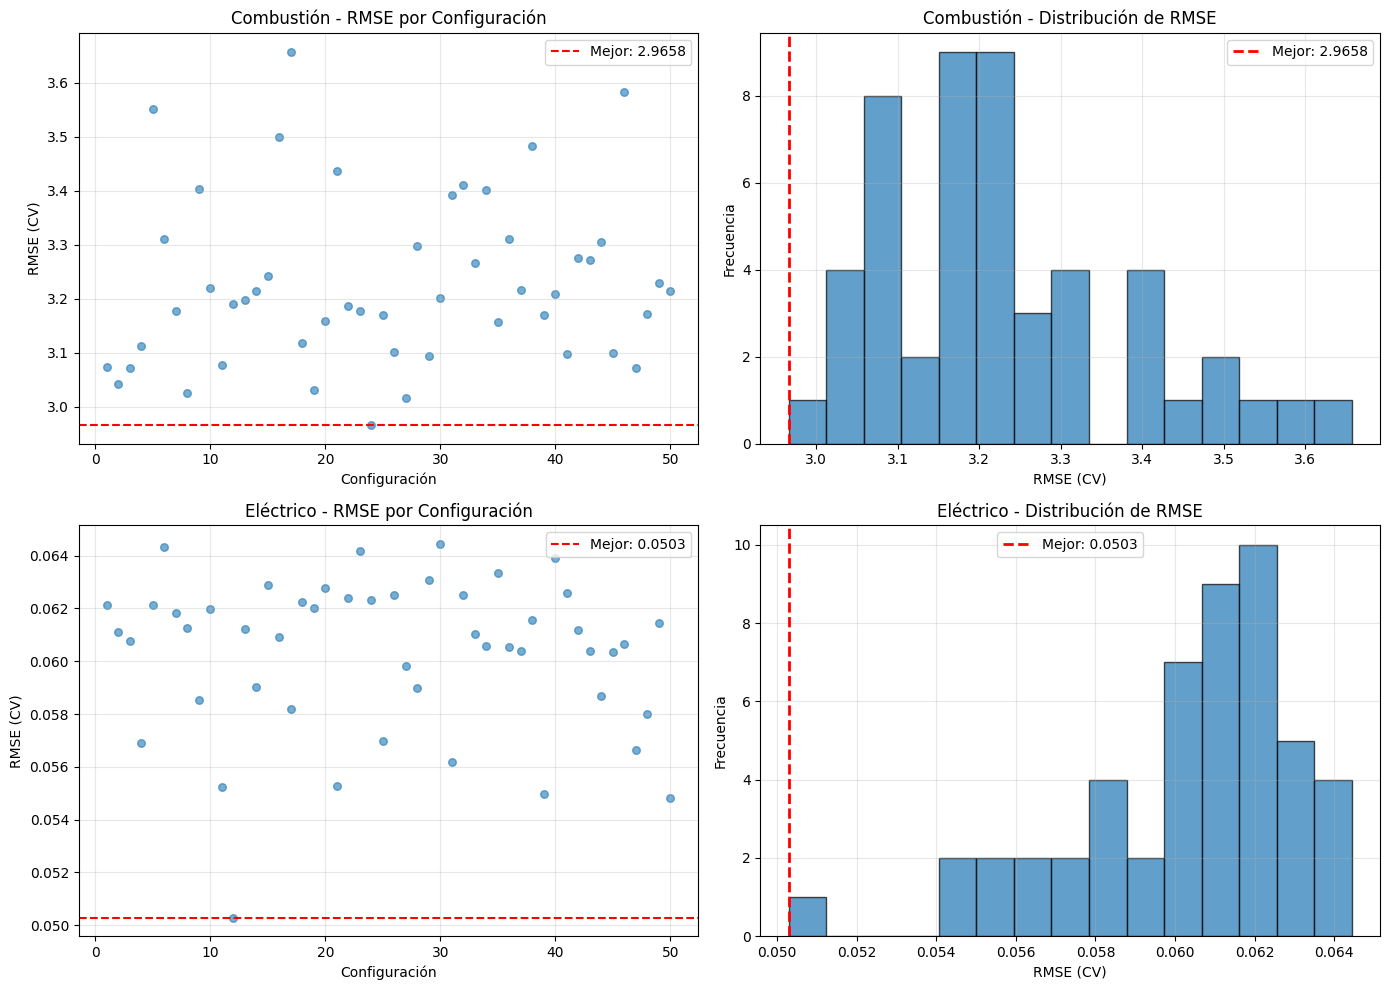

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, (search, name) in enumerate([(random_search_combustion, 'Combustión'), 
                                        (random_search_electric, 'Eléctrico')]):
    cv_results = pd.DataFrame(search.cv_results_)
    scores = -cv_results['mean_test_score'].values
    
    # RMSE por configuración
    ax1 = axes[idx, 0]
    ax1.scatter(range(1, len(scores)+1), scores, alpha=0.6, s=30)
    ax1.axhline(y=-search.best_score_, color='r', linestyle='--', 
                label=f'Mejor: {-search.best_score_:.4f}')
    ax1.set_xlabel('Configuración')
    ax1.set_ylabel('RMSE (CV)')
    ax1.set_title(f'{name} - RMSE por Configuración')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Distribución de scores
    ax2 = axes[idx, 1]
    ax2.hist(scores, bins=15, edgecolor='black', alpha=0.7)
    ax2.axvline(x=-search.best_score_, color='r', linestyle='--', linewidth=2, 
                label=f'Mejor: {-search.best_score_:.4f}')
    ax2.set_xlabel('RMSE (CV)')
    ax2.set_ylabel('Frecuencia')
    ax2.set_title(f'{name} - Distribución de RMSE')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
def train_final_model(X_dev_scaled, y_dev, best_params, target_name):
    print(f"ENTRENAMIENTO FINAL: {target_name}")
    
    final_params = best_params.copy()
    final_params['n_estimators'] = 1000
    final_params['early_stopping_rounds'] = 50
    
    print("Configuración del modelo final:")
    for param, value in final_params.items():
        if isinstance(value, float):
            print(f"  {param}: {value:.4f}")
        else:
            print(f"  {param}: {value}")
    
    model = xgb.XGBRegressor(
        **final_params,
        objective='reg:squarederror',
        random_state=69,
        n_jobs=-1,
        verbosity=1
    )
    
    # Split para early stopping (90% train, 10% val)
    X_train, X_val, y_train, y_val = train_test_split(
        X_dev_scaled, y_dev, test_size=0.1, random_state=69
    )
    
    print(f"\nTrain: {len(X_train)} samples, Validation: {len(X_val)} samples")
    print("Entrenando...")
    
    start_time = time.time()
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=50)
    elapsed_time = time.time() - start_time
    
    print(f"\nCompletado en {elapsed_time:.1f} segundos")
    print(f"Iteraciones usadas: {model.best_iteration}")
    print(f"Mejor RMSE (validation): {model.best_score:.6f}")
    
    return model
model_combustion = train_final_model(X_combustion_dev_scaled, y_combustion_dev, random_search_combustion.best_params_, "Combustión (L/100km)")

ENTRENAMIENTO FINAL: Combustión (L/100km)
Configuración del modelo final:
  colsample_bytree: 0.7131
  gamma: 0.3428
  learning_rate: 0.2449
  max_depth: 11
  min_child_weight: 1
  n_estimators: 1000
  reg_alpha: 0.5978
  reg_lambda: 0.0269
  subsample: 0.6413
  early_stopping_rounds: 50

Train: 19175 samples, Validation: 2131 samples
Entrenando...
[0]	validation_0-rmse:3.30185
[50]	validation_0-rmse:1.72940
[100]	validation_0-rmse:1.72381
[150]	validation_0-rmse:1.72424
[153]	validation_0-rmse:1.72394

Completado en 1.0 segundos
Iteraciones usadas: 103
Mejor RMSE (validation): 1.723691


In [10]:
model_electric = train_final_model(X_electric_dev_scaled, y_electric_dev, random_search_electric.best_params_, "Eléctrico (kWh/km)")

ENTRENAMIENTO FINAL: Eléctrico (kWh/km)
Configuración del modelo final:
  colsample_bytree: 0.8866
  gamma: 0.0037
  learning_rate: 0.0796
  max_depth: 6
  min_child_weight: 6
  n_estimators: 1000
  reg_alpha: 0.1345
  reg_lambda: 1.7547
  subsample: 0.9333
  early_stopping_rounds: 50

Train: 2969 samples, Validation: 330 samples
Entrenando...
[0]	validation_0-rmse:0.09154
[50]	validation_0-rmse:0.05279
[100]	validation_0-rmse:0.05208
[150]	validation_0-rmse:0.05195
[200]	validation_0-rmse:0.05191
[250]	validation_0-rmse:0.05183
[297]	validation_0-rmse:0.05191

Completado en 0.3 segundos
Iteraciones usadas: 247
Mejor RMSE (validation): 0.051830


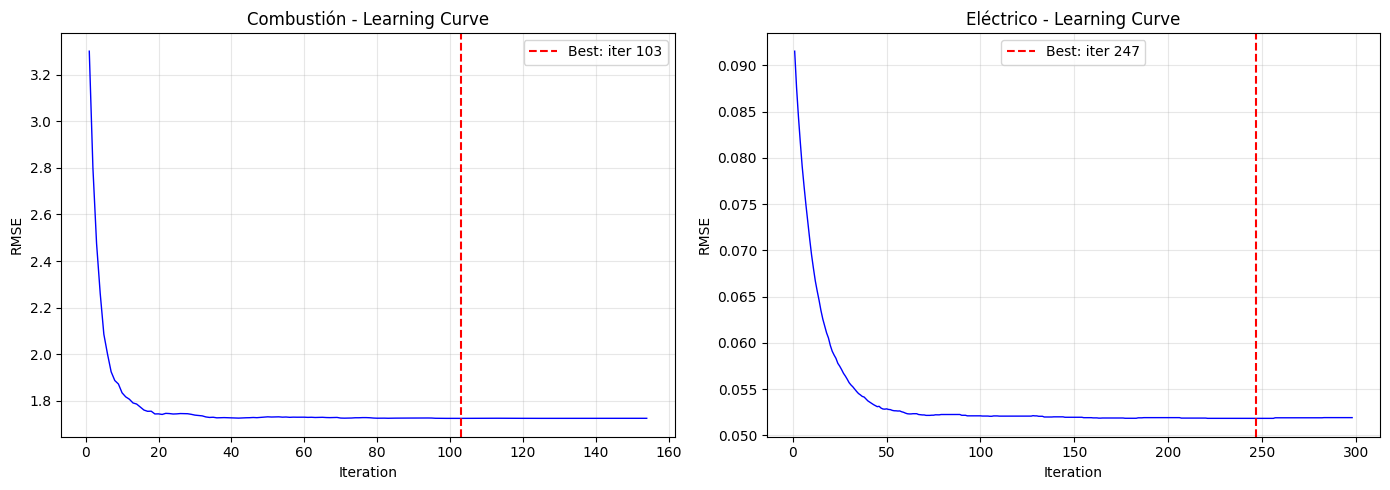

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (model, name) in enumerate([(model_combustion, 'Combustión'), 
                                      (model_electric, 'Eléctrico')]):
    results = model.evals_result()
    if 'validation_0' in results:
        val_rmse = results['validation_0']['rmse']
        
        ax = axes[idx]
        ax.plot(range(1, len(val_rmse)+1), val_rmse, 'b-', linewidth=1)
        ax.axvline(x=model.best_iteration, color='r', linestyle='--', 
                   label=f'Best: iter {model.best_iteration}')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('RMSE')
        ax.set_title(f'{name} - Learning Curve')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
X_combustion_test_scaled = scaler_combustion.transform(X_combustion_test)
X_combustion_test_scaled = pd.DataFrame(X_combustion_test_scaled, columns=sanitized_feature_cols, index=X_combustion_test.index)

X_electric_test_scaled = scaler_electric.transform(X_electric_test)
X_electric_test_scaled = pd.DataFrame(X_electric_test_scaled, columns=sanitized_feature_cols, index=X_electric_test.index)

def calculate_metrics(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mask = y_true > 0.001
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / np.abs(y_true[mask]))) * 100
    else:
        mape = np.nan
    
    return {'name': name, 'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2, 'mape': mape}

y_pred_combustion = model_combustion.predict(X_combustion_test_scaled)
metrics_combustion = calculate_metrics(y_combustion_test, y_pred_combustion, 'Combustión (L/100km)')

print("MODELO COMBUSTIÓN (L/100km)")
print(f"Test samples: {len(y_combustion_test)}")
print(f"MSE:  {metrics_combustion['mse']:.6f}")
print(f"RMSE: {metrics_combustion['rmse']:.4f}")
print(f"MAE:  {metrics_combustion['mae']:.4f}")
print(f"R²:   {metrics_combustion['r2']:.4f}")
print(f"MAPE: {metrics_combustion['mape']:.2f}%")

y_pred_electric = model_electric.predict(X_electric_test_scaled)
metrics_electric = calculate_metrics(y_electric_test, y_pred_electric, 'Eléctrico (kWh/km)')

print(f"\nMODELO ELÉCTRICO (kWh/km)")
print(f"Test samples: {len(y_electric_test)}")
print(f"MSE:  {metrics_electric['mse']:.6f}")
print(f"RMSE: {metrics_electric['rmse']:.4f}")
print(f"MAE:  {metrics_electric['mae']:.4f}")
print(f"R²:   {metrics_electric['r2']:.4f}")
if not np.isnan(metrics_electric['mape']):
    print(f"MAPE: {metrics_electric['mape']:.2f}%")

cv_rmse_combustion = -random_search_combustion.best_score_
cv_rmse_electric = -random_search_electric.best_score_

print(f"Combustión - Train RMSE: {cv_rmse_combustion:.4f}, Test RMSE: {metrics_combustion['rmse']:.4f}")
print(f"Eléctrico  - Train RMSE: {cv_rmse_electric:.4f}, Test RMSE: {metrics_electric['rmse']:.4f}")

MODELO COMBUSTIÓN (L/100km)
Test samples: 5327
MSE:  5.497803
RMSE: 2.3447
MAE:  1.1732
R²:   0.7815
MAPE: 14.92%

MODELO ELÉCTRICO (kWh/km)
Test samples: 825
MSE:  0.004492
RMSE: 0.0670
MAE:  0.0349
R²:   0.6477
MAPE: 97.52%
Combustión - Train RMSE: 2.9658, Test RMSE: 2.3447
Eléctrico  - Train RMSE: 0.0503, Test RMSE: 0.0670


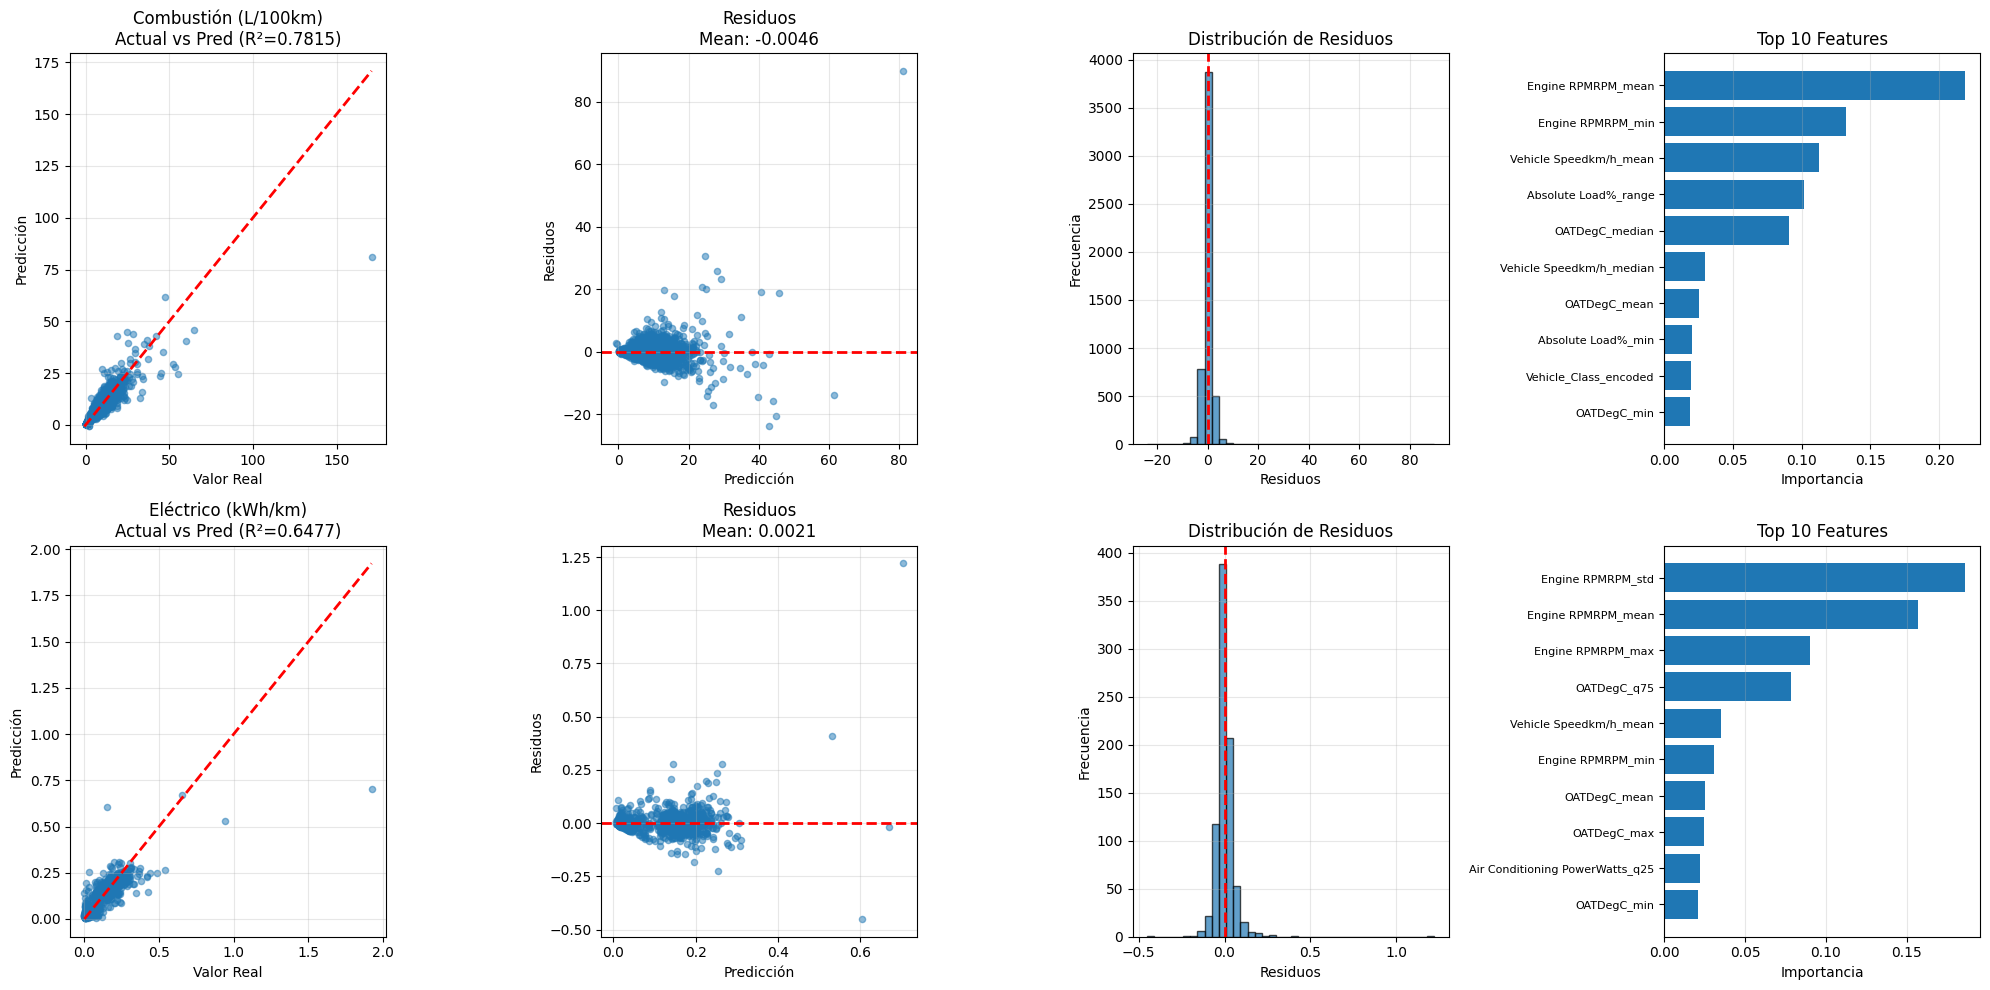

In [13]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for row, (y_true, y_pred, model, name) in enumerate([
    (y_combustion_test, y_pred_combustion, model_combustion, 'Combustión (L/100km)'),
    (y_electric_test, y_pred_electric, model_electric, 'Eléctrico (kWh/km)')
]):
    r2 = r2_score(y_true, y_pred)
    residuals = y_true - y_pred
    
    # 1. Actual vs Predicted
    ax1 = axes[row, 0]
    ax1.scatter(y_true, y_pred, alpha=0.5, s=20)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    ax1.set_xlabel('Valor Real')
    ax1.set_ylabel('Predicción')
    ax1.set_title(f'{name}\nActual vs Pred (R²={r2:.4f})')
    ax1.grid(True, alpha=0.3)
    
    # 2. Residuos
    ax2 = axes[row, 1]
    ax2.scatter(y_pred, residuals, alpha=0.5, s=20)
    ax2.axhline(y=0, color='r', linestyle='--', lw=2)
    ax2.set_xlabel('Predicción')
    ax2.set_ylabel('Residuos')
    ax2.set_title(f'Residuos\nMean: {residuals.mean():.4f}')
    ax2.grid(True, alpha=0.3)
    
    # 3. Distribución de residuos
    ax3 = axes[row, 2]
    ax3.hist(residuals, bins=40, edgecolor='black', alpha=0.7)
    ax3.axvline(x=0, color='r', linestyle='--', lw=2)
    ax3.set_xlabel('Residuos')
    ax3.set_ylabel('Frecuencia')
    ax3.set_title('Distribución de Residuos')
    ax3.grid(True, alpha=0.3)
    
    # 4. Feature Importance
    ax4 = axes[row, 3]
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:10]
    ax4.barh(range(10), importances[indices][::-1])
    ax4.set_yticks(range(10))
    ax4.set_yticklabels([sanitized_feature_cols[i] for i in indices][::-1], fontsize=8)
    ax4.set_xlabel('Importancia')
    ax4.set_title('Top 10 Features')
    ax4.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'final_models_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

In [14]:
mean_pred_comb = np.full(len(y_combustion_test), y_combustion_dev.mean())
median_pred_comb = np.full(len(y_combustion_test), np.median(y_combustion_dev))

baseline_comb = pd.DataFrame({
    'Model': ['XGBoost', 'Baseline (Mean)', 'Baseline (Median)'],
    'RMSE': [
        metrics_combustion['rmse'],
        np.sqrt(mean_squared_error(y_combustion_test, mean_pred_comb)),
        np.sqrt(mean_squared_error(y_combustion_test, median_pred_comb))
    ],
    'R2': [
        metrics_combustion['r2'],
        r2_score(y_combustion_test, mean_pred_comb),
        r2_score(y_combustion_test, median_pred_comb)
    ]
})

print("\nCOMBUSTIÓN (L/100km):")
display(baseline_comb)
rmse_improvement_comb = (baseline_comb.iloc[1]['RMSE'] - baseline_comb.iloc[0]['RMSE']) / baseline_comb.iloc[1]['RMSE'] * 100
print(f"Mejora sobre Mean Baseline: {rmse_improvement_comb:.1f}% en RMSE")

mean_pred_elec = np.full(len(y_electric_test), y_electric_dev.mean())
median_pred_elec = np.full(len(y_electric_test), np.median(y_electric_dev))

baseline_elec = pd.DataFrame({
    'Model': ['XGBoost', 'Baseline (Mean)', 'Baseline (Median)'],
    'RMSE': [
        metrics_electric['rmse'],
        np.sqrt(mean_squared_error(y_electric_test, mean_pred_elec)),
        np.sqrt(mean_squared_error(y_electric_test, median_pred_elec))
    ],
    'R2': [
        metrics_electric['r2'],
        r2_score(y_electric_test, mean_pred_elec),
        r2_score(y_electric_test, median_pred_elec)
    ]
})

print("\nELÉCTRICO (kWh/km):")
display(baseline_elec)
rmse_improvement_elec = (baseline_elec.iloc[1]['RMSE'] - baseline_elec.iloc[0]['RMSE']) / baseline_elec.iloc[1]['RMSE'] * 100
print(f"Mejora sobre Mean Baseline: {rmse_improvement_elec:.1f}% en RMSE")


COMBUSTIÓN (L/100km):


,Model,RMSE,R2
0,XGBoost,2.344739,0.781530
1,Baseline (Mean),5.016546,-0.000030
2,Baseline (Median),5.057126,-0.016275


Mejora sobre Mean Baseline: 53.3% en RMSE

ELÉCTRICO (kWh/km):


,Model,RMSE,R2
0,XGBoost,0.067020,0.647670
1,Baseline (Mean),0.112910,-0.000018
2,Baseline (Median),0.113101,-0.003399


Mejora sobre Mean Baseline: 40.6% en RMSE


In [15]:
final_model_dir = MODELS_DIR / 'final'
final_model_dir.mkdir(parents=True, exist_ok=True)

# Guardar modelo COMBUSTIÓN
joblib.dump(model_combustion, final_model_dir / 'xgboost_combustion.pkl')
joblib.dump(random_search_combustion.best_params_, final_model_dir / 'best_params_combustion.pkl')
joblib.dump(scaler_combustion, final_model_dir / 'scaler_combustion.pkl')

# Guardar modelo ELÉCTRICO
joblib.dump(model_electric, final_model_dir / 'xgboost_electric.pkl')
joblib.dump(random_search_electric.best_params_, final_model_dir / 'best_params_electric.pkl')
joblib.dump(scaler_electric, final_model_dir / 'scaler_electric.pkl')

joblib.dump(sanitized_feature_cols, final_model_dir / 'feature_names.pkl')

final_metrics = {
    'combustion': {
        **metrics_combustion,
        'cv_rmse': cv_rmse_combustion,
        'best_iteration': model_combustion.best_iteration,
        'n_train_samples': len(X_combustion_dev),
        'n_test_samples': len(X_combustion_test),
        'vehicle_types': ['ICE', 'HEV', 'PHEV']
    },
    'electric': {
        **metrics_electric,
        'cv_rmse': cv_rmse_electric,
        'best_iteration': model_electric.best_iteration,
        'n_train_samples': len(X_electric_dev),
        'n_test_samples': len(X_electric_test),
        'vehicle_types': ['PHEV', 'EV']
    },
    'n_features': len(sanitized_feature_cols),
}
joblib.dump(final_metrics, final_model_dir / 'final_metrics.pkl')

['models\\saved_models\\final\\final_metrics.pkl']

In [16]:
demo_dir = MODELS_DIR / 'final' / 'demo_samples'
demo_dir.mkdir(parents=True, exist_ok=True)

#   SAMPLES DE COMBUSTIÓN
demo_combustion = data_combustion.iloc[idx_test_comb].copy()
demo_combustion = demo_combustion.reset_index(drop=True)
demo_combustion_sample = demo_combustion.sample(n=min(50, len(demo_combustion)), random_state=42)
demo_combustion_sample.to_csv(demo_dir / 'demo_combustion.csv', index=False)

#   SAMPLES DE ELÉCTRICO
demo_electric = data_electric.iloc[idx_test_elec].copy()
demo_electric = demo_electric.reset_index(drop=True)
demo_electric_sample = demo_electric.sample(n=min(50, len(demo_electric)), random_state=42)
demo_electric_sample.to_csv(demo_dir / 'demo_electric.csv', index=False)

#   SAMPLES MIXTOS (PHEV que tienen ambos targets) 
phev_combustion_ids = set(demo_combustion[demo_combustion['Vehicle Type'] == 'PHEV']['filename'].values)
phev_electric_ids = set(demo_electric[demo_electric['Vehicle Type'] == 'PHEV']['filename'].values)
phev_both_ids = phev_combustion_ids.intersection(phev_electric_ids)

if len(phev_both_ids) > 0:
    demo_phev = data_full[data_full['filename'].isin(phev_both_ids)].copy()
    demo_phev = demo_phev[
        (demo_phev['Y_consumption_combustion_L_per_100km'] > 0) & 
        (demo_phev['Y_consumption_electric_kWh_per_km'] > 0)
    ]
    demo_phev_sample = demo_phev.sample(n=min(20, len(demo_phev)), random_state=42)
    demo_phev_sample.to_csv(demo_dir / 'demo_phev_both.csv', index=False)
    print(f"PHEV (ambos targets): {len(demo_phev_sample)} samples")

print(f"\nSamples de demostración guardados en {demo_dir}:")
print(f"Combustión: {len(demo_combustion_sample)} samples")
print(f"Eléctrico: {len(demo_electric_sample)} samples")

joblib.dump(feature_cols, demo_dir / 'original_feature_cols.pkl')

PHEV (ambos targets): 20 samples

Samples de demostración guardados en models\saved_models\final\demo_samples:
Combustión: 50 samples
Eléctrico: 50 samples


['models\\saved_models\\final\\demo_samples\\original_feature_cols.pkl']